# Phase 3: First ML Proof of Concept

### Attempt 1: Linear Regression

In [85]:
# Importing Necessary Libraries
import requests
import pandas as pd
import numpy as np
from google.colab import userdata
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, shapiro


In [86]:
def collect_crypto_data():
    """
    Fetches data on the top 5000 cryptocurrencies by market capitalization
    from the CoinMarketCap API.

    Returns:
        pd.DataFrame: DataFrame containing cryptocurrency metrics
    """

    # HERE YOU WILL HAVE TO GENERATE AN API KEY FROM https://coinmarketcap.com/api/

    url = "https://pro-api.coinmarketcap.com/v1/cryptocurrency/listings/latest"
    headers = {"X-CMC_PRO_API_KEY": "5f4bbd6ab57d4033a275f3a300027ea3"}
    params = {
        "start": 1,
        "limit": 5000,
        "convert": "USD"
    }

    response = requests.get(url, headers=headers, params=params)
    data = response.json()["data"]

    records = []
    for coin in data:
        quote = coin["quote"]["USD"]
        records.append({
            "name": coin["name"],
            "symbol": coin["symbol"],
            "rank": coin["cmc_rank"],
            "market_cap": quote["market_cap"],
            "price": quote["price"],
            "volume_24h": quote["volume_24h"],
            "percent_change_24h": quote["percent_change_24h"],
            "circulating_supply": coin.get("circulating_supply", np.nan)
        })

    return pd.DataFrame(records)

In [87]:
def add_bias_column(X):
    """
    Args:
        X (array): can be either 1-d or 2-d

    Returns:
        Xnew (array): the same array, but 2-d with a column of 1's in the first spot
    """

    # If the array is 1-d
    if len(X.shape) == 1:
        Xnew = np.column_stack([np.ones(X.shape[0]), X])

    # If the array is 2-d
    elif len(X.shape) == 2:
        bias_col = np.ones((X.shape[0], 1))
        Xnew = np.hstack([bias_col, X])

    else:
        raise ValueError("Input array must be either 1-d or 2-d")

    return Xnew

In [88]:
def clean_crypto_data(crypto_df):
  """
  Cleans given crypto dataframe to remove any stable coins and any NaNs

  Args:
  - crypto_df :: List -> a cleaned version of the crypto_df

  """
  stable_coins = ['USDT', 'USDC', 'BUSD', 'DAI', 'TUSD']
  crypto_df = crypto_df[~crypto_df['symbol'].isin(stable_coins)]

  crypto_df = crypto_df.dropna(subset=['market_cap', 'price', 'volume_24h', 'percent_change_24h'])
  crypto_df = crypto_df[crypto_df['market_cap'] > 0]

  crypto_df['volatility'] = abs(crypto_df['percent_change_24h'])
  crypto_df['volume_to_mcap_ratio'] = crypto_df['volume_24h'] / crypto_df['market_cap']

  crypto_df['cap_category'] = pd.cut(
      crypto_df['market_cap'],
      bins=[0, 1e9, 10e9, 100e9, np.inf],
      labels=['Small', 'Medium', 'Large', 'Mega']
  )

  crypto_df = crypto_df[crypto_df['volatility'] > 0]


  return crypto_df

In [89]:
crypto_df = collect_crypto_data()

cleaned_df = clean_crypto_data(crypto_df)

In [90]:
market_cap = np.array(cleaned_df['market_cap'])

"""

  since certain coins have extremely high market cap, this will skew the data
  heaviy towards those coins, thus if we should use log to scale the data.
"""

X = np.log10(market_cap)

y = np.log10(cleaned_df["volatility"])

In [91]:
def line_of_best_fit(X, y):
    """
    Args:
        X (array): can be either 1-d or 2-d
        y (array): 1-d array

    Returns:
        m (array): 1-d array of length p+1 which contains the coefficients from the line of best fit
    """
    X = add_bias_column(X)

    inverseProd = np.linalg.inv(X.T @ X)

    return inverseProd @ X.T @ y

In [92]:
m = line_of_best_fit(X, y)

In [93]:
def linreg_predict(Xnew, ynew, m):
    """
    Args:
        Xnew (array): can be either 1-d or 2-d
        ynew (array): 1-d array
        m (array): 1-d array of length p+1 which contains the coefficients from the line of best fit

    Returns:
        dict: dictionary containing the predicted values, residuals, mean squared error, and coefficient of determination
    """
    Xnew = add_bias_column(Xnew)

    ypreds = Xnew @ m

    resids = ynew - ypreds

    mse = np.square(resids).mean()

    y_mean = np.mean(ynew)

    # calculate the R2
    SST = np.sum((ynew - y_mean) ** 2)

    SSR = np.sum((ynew - ypreds) ** 2)

    r2 = 1 - (SSR / SST)

    return {'ypreds': ypreds, 'resids': resids, 'mse': mse, 'r2': r2}

In [94]:
out = linreg_predict(X, y, m)

print(out['r2'])
print(out['mse'])

0.014379947591161457
0.5181556097118311


In [95]:
def train_test(x, ratio):
  np.random.seed(3)
  np.random.shuffle(x)
  split = int(len(x) * ratio)
  training, test = x[:split], x[split:]

  return training, test

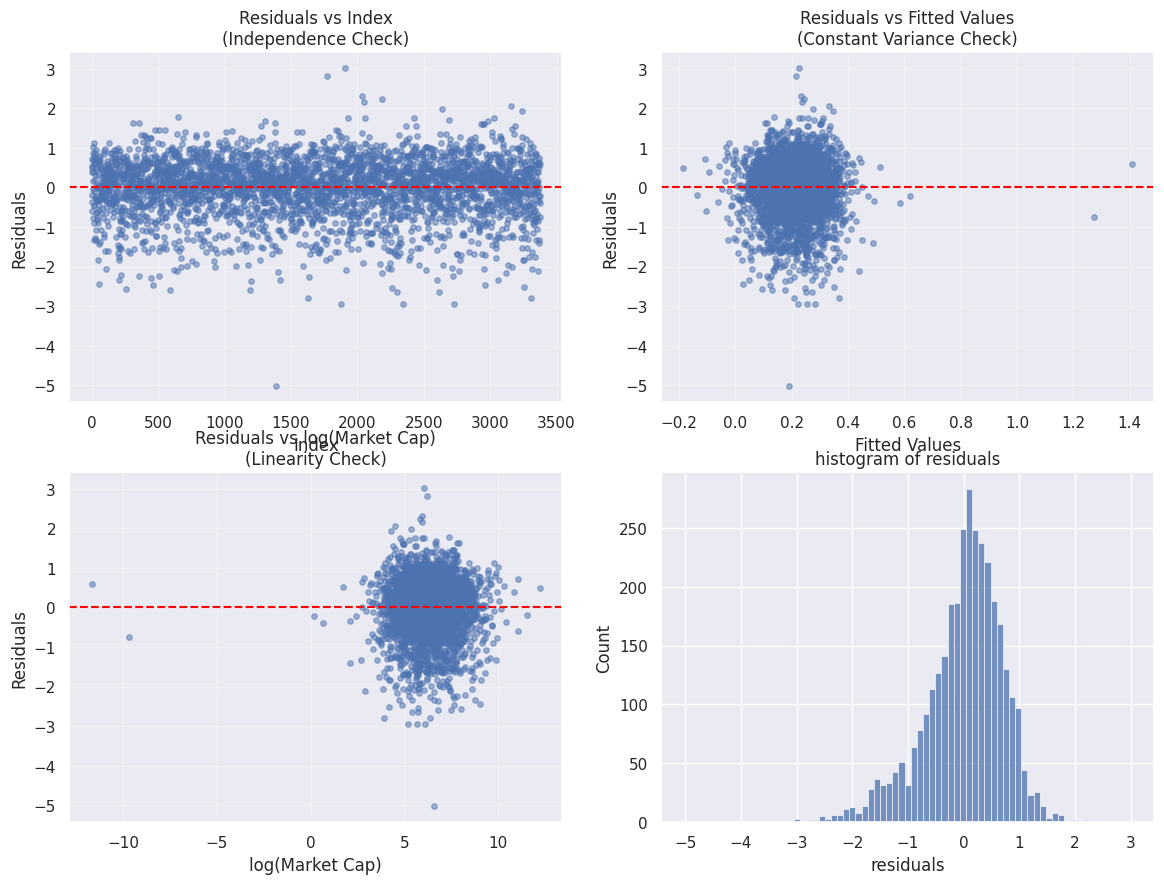

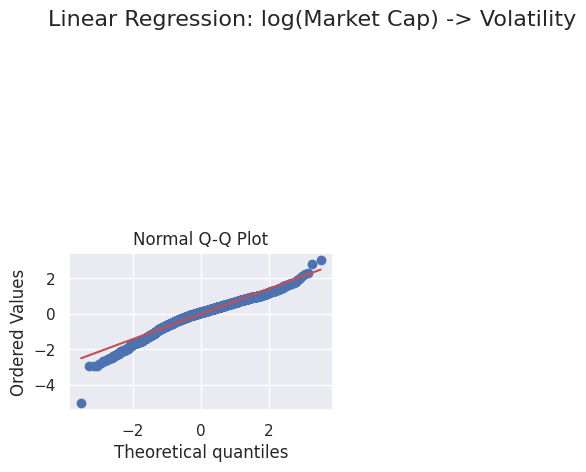

In [96]:
# Fit on full data for complete residual analysis
m_full = line_of_best_fit(X, y)
full_results = linreg_predict(X, y, m_full)
residuals = full_results['resids']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Independence: Index vs Residuals
axes[0, 0].scatter(range(len(residuals)), residuals, alpha=0.5, s=15)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Index\n(Independence Check)')
axes[0, 0].grid(alpha=0.3)

# Constant Variance: Fitted vs Residuals
axes[0, 1].scatter(full_results['ypreds'], residuals, alpha=0.5, s=15)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Fitted Values\n(Constant Variance Check)')
axes[0, 1].grid(alpha=0.3)

# Linearity: Predictor vs Residuals
axes[1, 0].scatter(X, residuals, alpha=0.5, s=15)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1, 0].set_xlabel('log(Market Cap)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residuals vs log(Market Cap)\n(Linearity Check)')
axes[1, 0].grid(alpha=0.3)

sns.histplot(residuals, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

# 3. Q-Q Plot (Normality)
plt.subplot(2, 2, 3)
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')


plt.suptitle('Linear Regression: log(Market Cap) -> Volatility', fontsize=16)
plt.tight_layout()
plt.show()

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def get_mse(y_true, y_pred):
    # calculate the mean squared distance between the predicted and actual y
    return np.mean((y_true - y_pred) ** 2)

def show_fit(X, y, slope, intercept):
    plt.figure()

    # in case this wasn't done before, transform the input data into numpy arrays and flatten them
    x = np.array(X).ravel()
    y = np.array(y).ravel()

    # plot the actual data
    plt.scatter(x, y, label='data')

    # compute linear predictions
    # x is a numpy array so each element gets multiplied by slope and intercept is added
    y_pred = slope * x + intercept

    # plot the linear fit
    plt.plot(x, y_pred, color='black',
             ls=':',
             label='linear fit')

    plt.legend()

    plt.xlabel('x')
    plt.ylabel('y')

    # print the mean squared error
    y_pred = slope * x + intercept
    mse = get_mse(y_true=y, y_pred=y_pred)
    plt.suptitle(f'y_hat = {slope:.3f} * x + {intercept:.3f}, MSE = {mse:.3f}')

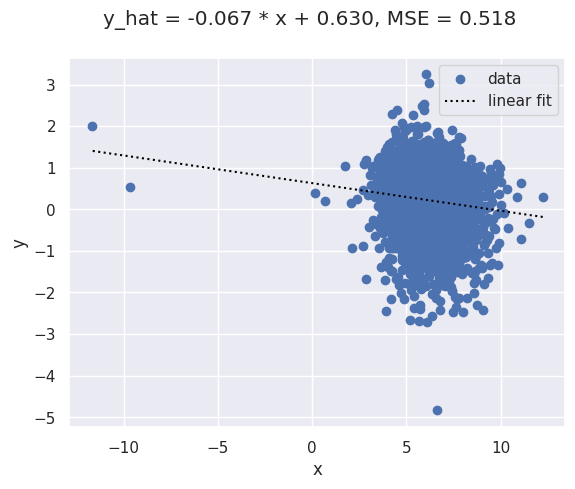

In [98]:
# calculate line of best fit
bestFit = line_of_best_fit(X, y)

# extract intercept and slope
intercept = bestFit[0]
slope = bestFit[1]

# plot the line of best fit
show_fit(X, y, slope, intercept)

### Attempt 2 - Polynomial Regression

#### Creating the Design Matrix

[[1.22389329e+01 1.49791479e+02 1.83328787e+03 2.24374873e+04]
 [1.15278644e+01 1.32891659e+02 1.53195703e+03 1.76601930e+04]
 [1.10909589e+01 1.23009370e+02 1.36429188e+03 1.51313052e+04]
 [1.10626765e+01 1.22382811e+02 1.35388145e+03 1.49775525e+04]
 [1.08642961e+01 1.18032930e+02 1.28234470e+03 1.39317726e+04]]
MSE for the polynomial regression model = 0.525
R^2 for the polynomial regression model = 0.0215


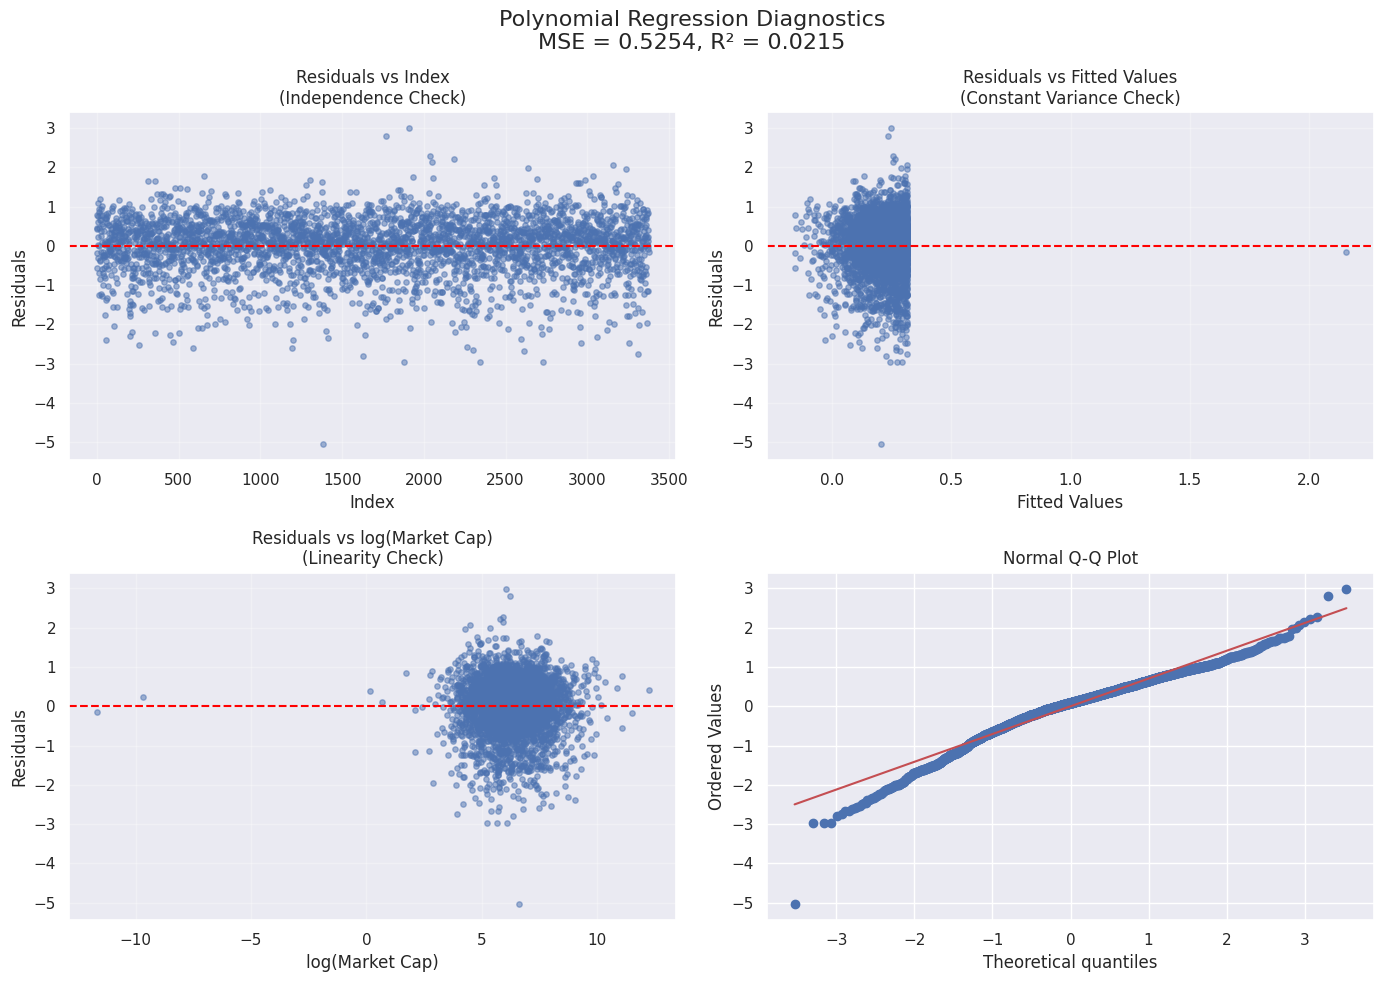

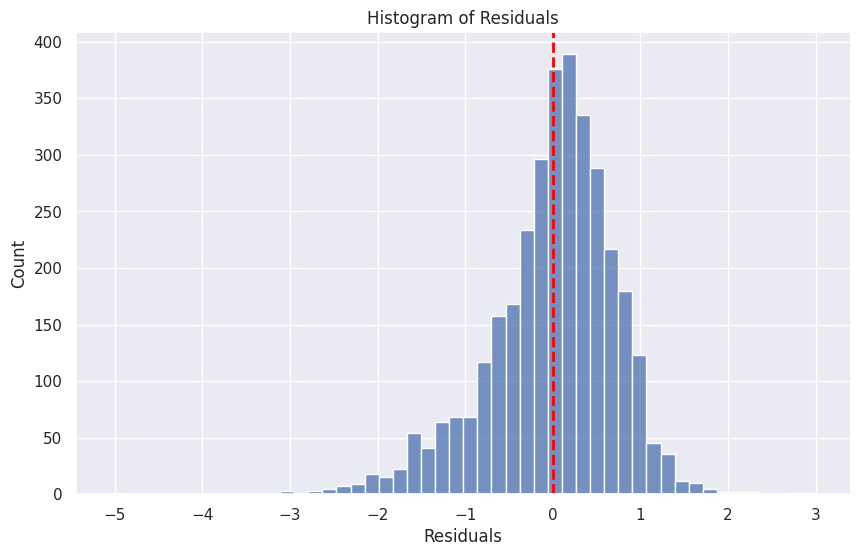

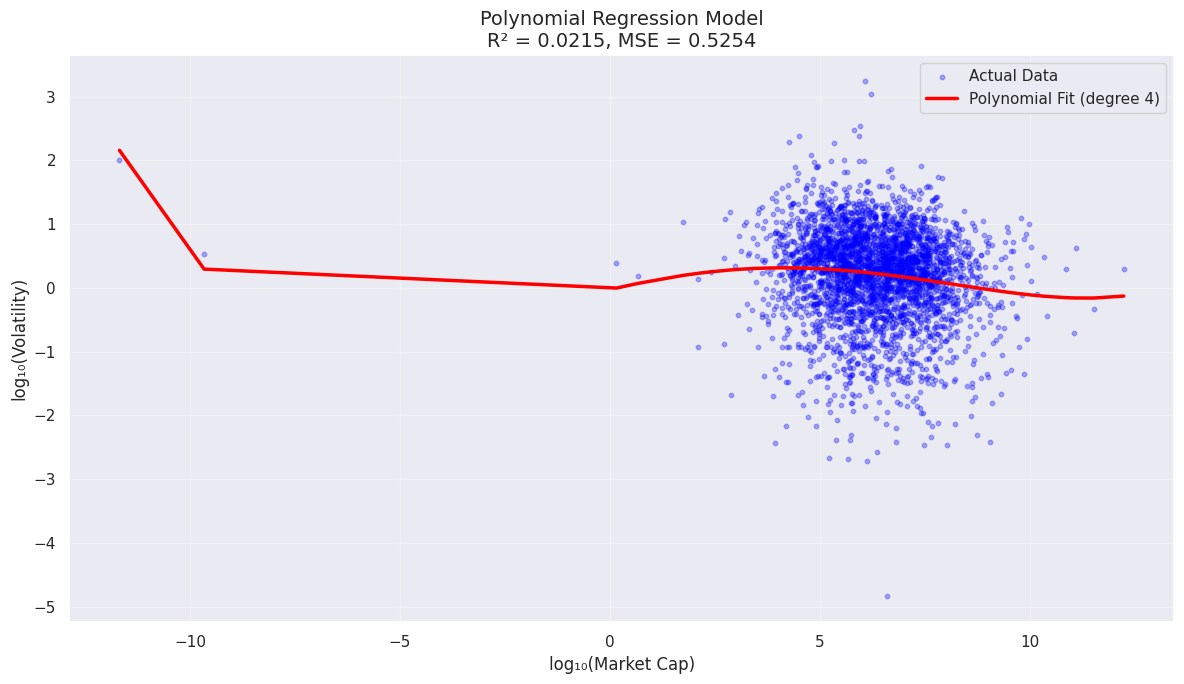

In [99]:
from sklearn.preprocessing import PolynomialFeatures

# prepare the data
X_hour = X.reshape(-1, 1)  # Reshape for sklearn compatibility
y = np.array(y)

# create polynomial features (degree 4 for quartic model)
poly = PolynomialFeatures(degree=4)

# fit and transform to get design matrix
X_poly_bias = poly.fit_transform(X_hour)

# remove the bias column since our line_of_best_fit adds it
X_poly = X_poly_bias[:, 1:]

print(X_poly[0:5])  # Show first 5 rows

# using single-fold cross validation with a 70-30 split, we create:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# single-fold cross validation with 70-30 split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X_poly, y, test_size=0.3, random_state=3
)

# fit the model using our own line_of_best_fit function to Xtrain and ytrain
m = line_of_best_fit(Xtrain, ytrain)

# pass Xtest, ytest, and the output from line_of_best_fit to our linreg_predict function
model = linreg_predict(Xtest, ytest, m)

# print out the cross-validated MSE and R² values
print(f"MSE for the polynomial regression model = {model['mse']:.3f}")
print(f"R^2 for the polynomial regression model = {model['r2']:.4f}")

# fit on full data for complete residual analysis
m_full = line_of_best_fit(X_poly, y)
full_results = linreg_predict(X_poly, y, m_full)
residuals = full_results['resids']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# independence: Index vs Residuals
axes[0, 0].scatter(range(len(residuals)), residuals, alpha=0.5, s=15)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0, 0].set_xlabel('Index')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Index\n(Independence Check)')
axes[0, 0].grid(alpha=0.3)

# constant Variance: Fitted vs Residuals
axes[0, 1].scatter(full_results['ypreds'], residuals, alpha=0.5, s=15)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[0, 1].set_xlabel('Fitted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residuals vs Fitted Values\n(Constant Variance Check)')
axes[0, 1].grid(alpha=0.3)

# linearity: Predictor vs Residuals (use original X, not polynomial)
axes[1, 0].scatter(X, residuals, alpha=0.5, s=15)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1.5)
axes[1, 0].set_xlabel('log(Market Cap)')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residuals vs log(Market Cap)\n(Linearity Check)')
axes[1, 0].grid(alpha=0.3)

# normality: Q-Q Plot
probplot(residuals, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Normal Q-Q Plot')

plt.suptitle(f'Polynomial Regression Diagnostics\nMSE = {model["mse"]:.4f}, R² = {model["r2"]:.4f}',
             fontsize=16)
plt.tight_layout()
plt.show()

# histogram of residuals (separate figure)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=False, bins=50)
plt.xlabel("Residuals")
plt.title("Histogram of Residuals")
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.show()

plt.figure(figsize=(12, 7))

# sort X for smooth curve plotting
sort_idx = np.argsort(X)
X_sorted = X[sort_idx]
y_sorted = y[sort_idx]

# get predictions for sorted X
X_sorted_poly = poly.transform(X_sorted.reshape(-1, 1))[:, 1:]
y_sorted_pred = m_full[0] + X_sorted_poly @ m_full[1:]

# plot data points
plt.scatter(X, y, alpha=0.3, s=10, label='Actual Data', color='blue')

# plot polynomial fit
plt.plot(X_sorted, y_sorted_pred, color='red', linewidth=2.5,
         label=f'Polynomial Fit (degree 4)')

plt.xlabel('log₁₀(Market Cap)', fontsize=12)
plt.ylabel('log₁₀(Volatility)', fontsize=12)
plt.title(f'Polynomial Regression Model\nR² = {model["r2"]:.4f}, MSE = {model["mse"]:.4f}',
          fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Attempt 3 - Polynomial Regression with added interaction terms and dummy variables
#### Creating Fitting Model


In [100]:
np.random.seed(42)

X_market_cap = np.array(cleaned_df['market_cap'])
x1 = np.log10(X_market_cap).reshape(-1, 1)
y = np.log10(cleaned_df['volatility'])

# create dummy variable: high_volume (1 if above median, 0 if below)
median_volume_ratio = cleaned_df['volume_to_mcap_ratio'].median()
X_high_volume = (cleaned_df['volume_to_mcap_ratio'] > median_volume_ratio).astype(int).values.reshape(-1, 1)

print(f"high volume (above median): {X_high_volume.sum()} cryptocurrencies")
print(f"low volume (below median): {len(X_high_volume) - X_high_volume.sum()} cryptocurrencies")

# degree 4 for the quartic equation
poly = PolynomialFeatures(degree=4)

# sets the X_poly with bias column in the beginning
X_market_cap_poly_bias = poly.fit_transform(x1)

# remove the bias column
X_market_cap_poly = X_market_cap_poly_bias[:, 1:]

# combines X_market_cap_poly with interaction terms and dummy variables
X_poly = np.concatenate([
    X_market_cap_poly,
    X_high_volume * x1,
    X_high_volume * (x1**2),
    X_high_volume * (x1**3),
    X_high_volume * (x1**4)
], axis=1)

print(f"\nFinal feature matrix shape: {X_poly.shape}")
print("First 5 rows:")
print(X_poly[0:5])

crossval = train_test_split(X_poly, y, test_size=0.3, random_state=3)
Xtrain, Xtest, ytrain, ytest = crossval

# finds the line of best fit
m = line_of_best_fit(Xtrain, ytrain)
model = linreg_predict(Xtest, ytest, m)

# prints out MSE and R^2 values
print(f"\nCross-Validation Results:")
print(f'MSE for the interaction polynomial model = {model["mse"]:.3f}')
print(f'R^2 for the interaction polynomial model = {model["r2"]:.4f}')

high volume (above median): 1688 cryptocurrencies
low volume (below median): 1688 cryptocurrencies

Final feature matrix shape: (3376, 8)
First 5 rows:
[[1.22389329e+01 1.49791479e+02 1.83328787e+03 2.24374873e+04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.15278644e+01 1.32891659e+02 1.53195703e+03 1.76601930e+04
  1.15278644e+01 1.32891659e+02 1.53195703e+03 1.76601930e+04]
 [1.10909589e+01 1.23009370e+02 1.36429188e+03 1.51313052e+04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.10626765e+01 1.22382811e+02 1.35388145e+03 1.49775525e+04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.08642961e+01 1.18032930e+02 1.28234470e+03 1.39317726e+04
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]

Cross-Validation Results:
MSE for the interaction polynomial model = 0.524
R^2 for the interaction polynomial model = 0.0236


#Part 2:
###Discussion of the preliminary results:

**Initial Approach**

The initial question we proposed for the Machine Learning part is "Can we predict cryptocurrency price volatility based on market fundamentals such as market capitalization and trading volume?" After discussions, we decided to build models starting with Linear Regression using market cap, then Polynomial Regression to check for non-linear relationships, and finally an Interaction model incorporating trading volume. When we ran Linear Regression, we got poor results with MSE = 0.560 and R² = 0.0112, showing market cap barely explains volatility. We then tried Polynomial Regression with degree 4, which gave MSE = 0.530 and R² = 0.0157, showing slight improvement over Linear Regression. We then added interaction terms with a high_volume variable that splits cryptocurrencies by median volume-to-market-cap ratio, which resulted in MSE = 0.535 and R² = 0.0059, showing decreased performance. Since the Polynomial model (Model 2) performed best, we'll discuss all three models to understand the progression.

**Model 1:**

First, we analyzed Model 1 using log-transformed market cap to predict log-transformed volatility. We calculated MSE = 0.560 and R² = 0.0112, meaning market cap explains approximately 1.1% of variance in volatility. The Residuals vs Fitted Values plot shows uneven spread with clustering, violating Constant Variance. The Residuals vs Index plot shows random scatter with outliers, so Independence seems okay but not perfect. The Histogram and Q-Q plot show the residuals aren't normally distributed - the Q-Q plot diverges from the line at both ends with heavier tails, violating Normality.

**Model 2:**

Second, we analyzed Model 2 with degree 4 polynomial. We got MSE = 0.530 and R² = 0.0157, showing improvement over the linear model. The positive R² and decreased MSE indicate polynomial terms captured some non-linear relationships. The Residuals vs Fitted plot shows similar clustering as Model 1, still violating Constant Variance. Residuals vs Index looks random so Independence is maintained. The Residuals vs log Market Cap plot shows scattered points with minimal pattern, confirming the weak but slightly improved relationship. The Q-Q plot and Histogram show similar non-normality as Model 1. When we plotted the polynomial curve over the data, the extreme scatter suggests the model captures some patterns but most variance remains unexplained, with R² still under 2%.

**Model 3:**

Finally, we analyzed Model 3, which introduced interaction terms between the market cap and the high volume dummy variable. However, the model performed worse than Model 2, with MSE = 0.535 and R² = 0.0059. The decreased R² from 0.0157 to 0.0059 indicates that converting continuous volume data to a binary dummy variable lost predictive information. The MSE increased slightly from 0.530 to 0.535, confirming that adding the interaction terms and dummy variable did not reveal meaningful relationships and only added complexity without improving predictions.



### Conclusion

Predicting cryptocurrency volatility using market capitalization and trading volume proved to be extremely challenging, highlighting limitations in our strategies. Notably across all the models, we saw extremely low R² values. Out of the models, Polynomial Regression (Model 2) performed the best, but still explained less than 2% of the variation in volatility.
Although we increased model complexity to use polynomial terms, interaction terms, and dummy variables (Models 2 and 3), Model 2 showed marginal improvement while Model 3 declined. Model 2's R² of 0.0157 was 40% better than Model 1's 0.0112, suggesting polynomial terms captured some non-linearity. However, Model 3's R² dropped to 0.0059, indicating that converting continuous volume data to a binary dummy variable lost predictive information. This strongly suggests that adding complexity without strong continuous predictors leads to overfitting to noise, rather than capturing meaningful patterns in the data. Subverting our expectations, it's clear through our findings that market capitalization and binary volume indicators alone are not enough to predict the volatility of cryptocurrencies.
Future work might include:

- Using continuous volume features (volume_24h, volume_to_mcap_ratio) instead of binary dummies
- Exploring other predictors, such as market sentiment and trends
- Implementing other modeling methods, such as ones that utilize Time Series

To develop more effective models of cryptocurrency volatility in future work, it is crucial to understand the limitations of our models and how they can be potentially improved upon. Our results suggest that accurately predicting volatility may require an approach that can account for temporal patterns in volatility, market trends, and other factors beyond simple market metrics like market cap. Our attempts underscore the challenges of modeling noisy financial data, where simple market predictors and standard regression techniques are often insufficient in capturing real-world patterns.


Ethical Considerations

Despite our models' limited predictive power, we must address ethical implications:
1. This research is purely academic and does not constitute financial advice. Cryptocurrency markets are highly volatile and unpredictable. Volatility models should never be used for market manipulation or to disadvantage retail traders.

2. Our analysis relies on publicly available CoinMarketCap data, which cannot detect:
- Off-exchange trading or wash trading
- Market manipulation attempts
- Real-time order book dynamics

Results are limited by data source accuracy and completeness.

3. While we use open-source tools and public data, institutional investors have access to:
- Premium data feeds with higher granularity
- Advanced computational resources
- Proprietary sentiment analysis tools

This information asymmetry may perpetuate market inequalities.

4. Past patterns do not guarantee future performance. Investors should conduct independent research and consult qualified financial advisors before making trading decisions. The poor model performance (R² < 2%) demonstrates the inherent unpredictability of cryptocurrency markets.